# Take a look at Transformer architecture
Architecture 
- Include building blocks: Input embedding, Positional encoding, Attention and Feed Forward
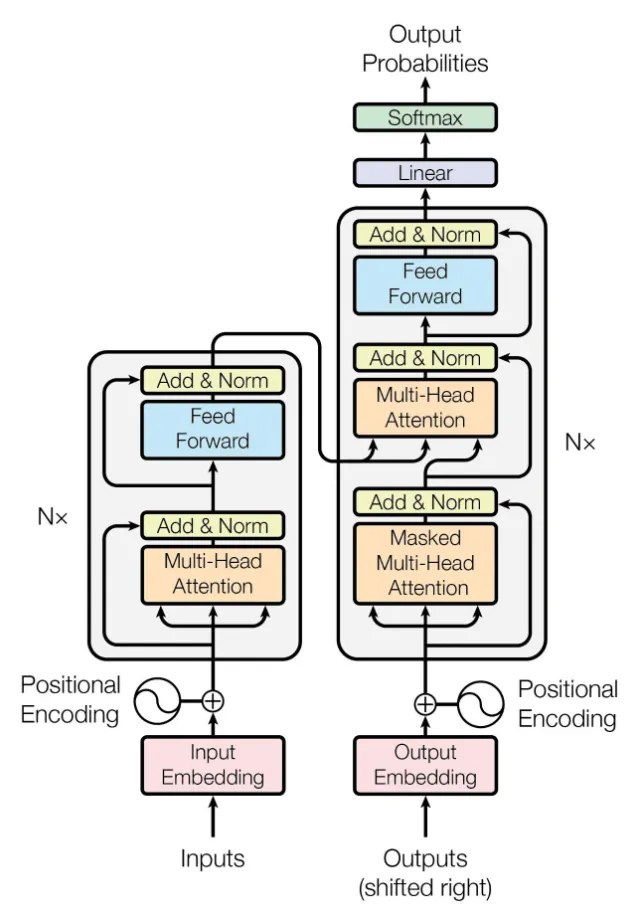

In [3]:
import torch
import torch.nn as nn


In [2]:
# Define the transformer model
model = nn.Transformer(
    d_model=1536,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6
)

# Print the model object
print(model)

d:\GitHub\Open source\data-science\LLMs\Understand Transformer\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1536, out_features=1536, bias=True)
        )
        (linear1): Linear(in_features=1536, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=1536, bias=True)
        (norm1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features

## Input embeddings
- Convert tokens into embedding vectors


In [4]:
import torch
import math
import torch.nn as nn

class InputEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, d_model: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model) # Scale by sqrt(d_model) is a standard practice

In [ ]:
# Create embeddings
embedding_layer = InputEmbeddings(vocab_size=10_000, d_model=512) # 10,000 words in vocab, 512-dimensional embeddings
embedded_output = embedding_layer(torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]]))
print(embedded_output.shape)  # torch.Size([2, 4, 512])
print(embedded_output)

torch.Size([2, 4, 512])
tensor([[[ 18.7443,  -0.1585,  15.0020,  ..., -18.7513, -15.7000,  20.7274],
         [ 12.4412, -67.3009,  -3.4322,  ...,  -5.7233,  -3.2890,  17.6181],
         [ 34.9658,  31.8084,   6.0143,  ..., -14.8686, -19.4940, -21.2493],
         [ 26.6961, -14.9234,   5.2665,  ...,   6.5346,  27.3336, -42.1881]],

        [[ 23.6339, -26.1005,   3.0120,  ...,  30.0675,   6.9642,   7.0583],
         [ 60.7942,   6.3393,  23.3539,  ...,  28.0001,  13.7267,  15.0368],
         [ 42.4954,   6.2674, -40.6553,  ...,  19.7734,  -3.2099,   1.8083],
         [  3.3396,  -9.9642,  28.7160,  ...,   4.3586, -37.2187, -14.6467]]],
       grad_fn=<MulBackward0>)


## Positional encoding
Use the sin and cosine mathematical functions, to generate unique positional embeddings. Sin is used for even embedding values, and cosine is used for odd values.

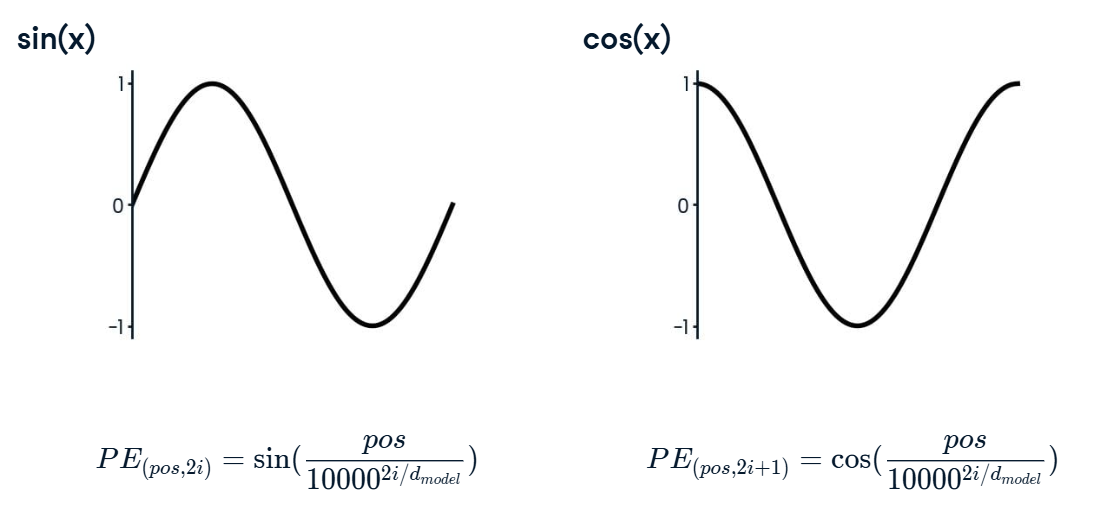

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [8]:
# Create positional encoding
pos_encoding_layer = PositionalEncoding(d_model=512, max_seq_length=4)
pos_encoded_output = pos_encoding_layer(embedded_output)
print(pos_encoded_output.shape)  # torch.Size([2, 4, 512])
print(pos_encoded_output)

torch.Size([2, 4, 512])
tensor([[[ 18.7443,   0.8415,  15.0020,  ..., -17.7513, -15.7000,  21.7274],
         [ 13.2827, -66.7606,  -2.6104,  ...,  -4.7233,  -3.2889,  18.6181],
         [ 35.8751,  31.3923,   6.9508,  ..., -13.8686, -19.4938, -20.2493],
         [ 26.8373, -15.9134,   5.5116,  ...,   7.5346,  27.3339, -41.1881]],

        [[ 23.6339, -25.1005,   3.0120,  ...,  31.0675,   6.9642,   8.0583],
         [ 61.6357,   6.8796,  24.1758,  ...,  29.0001,  13.7268,  16.0368],
         [ 43.4047,   5.8512, -39.7189,  ...,  20.7734,  -3.2097,   2.8083],
         [  3.4807, -10.9542,  28.9611,  ...,   5.3586, -37.2184, -13.6467]]],
       grad_fn=<AddBackward0>)


## Self-attentions mechanism
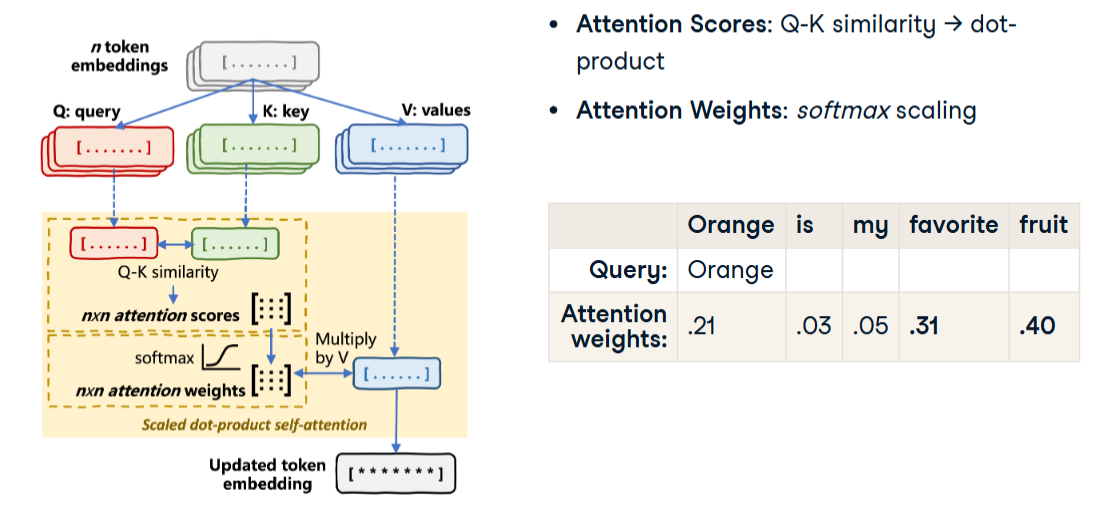

### Multi-head attention
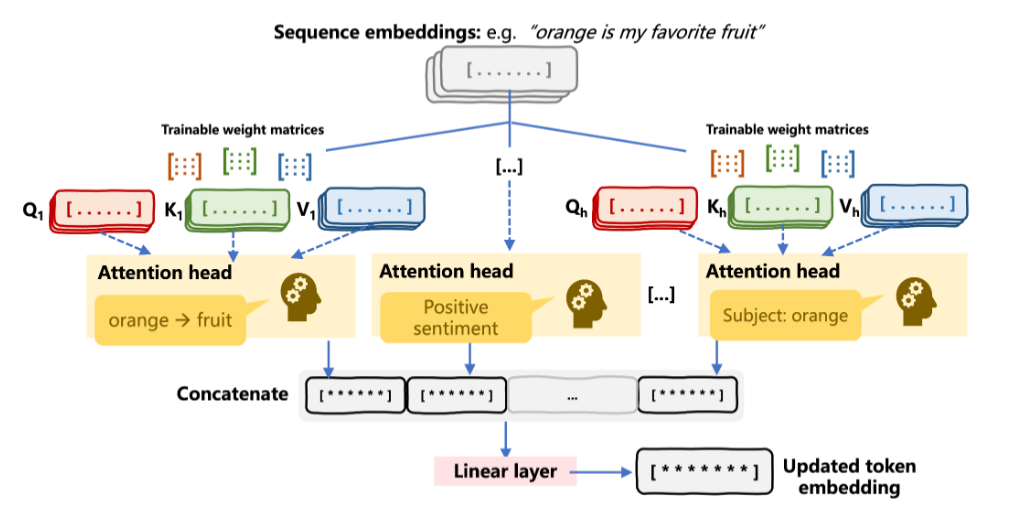

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads."
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.query_linear = nn.Linear(d_model, d_model, bias=False)
        self.key_linear = nn.Linear(d_model, d_model, bias=False)
        self.value_linear = nn.Linear(d_model, d_model, bias=False)
        self.output_linear = nn.Linear(d_model, d_model) # concatenate and project head outputs
    
    def split_heads(self, x, batch_size):        
        seq_length = x.size(1)
        # Split the input embeddings and permute        
        print(f"Before split heads shape: {x.shape}")  # Debugging line to check shape after splitting heads
        x = x.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        print(f"After split heads shape: {x.shape}")  # Debugging line to check shape after splitting heads
        permuted = x.permute(0, 2, 1, 3)
        print(f"Permuted shape: {permuted.shape}")  # Debugging line to check shape after permuting heads
        return permuted

    def compute_attention(self, query, key, value, mask=None):
        # Transpose (-2, -1) affect to two last dimension, ie. (num of elements in embeddings) and seq_length (num of tokens)
        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_dim ** 0.5) 
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = F.softmax(scores, dim=-1)
        return torch.matmul(attention_weights, value)

    def combine_heads(self, x, batch_size):
        x = x.permute(0, 2, 1, 3).contiguous()
        return x.view(batch_size, -1, self.d_model)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        query = self.split_heads(self.query_linear(query), batch_size)        
        key = self.split_heads(self.key_linear(key), batch_size)        
        value = self.split_heads(self.value_linear(value), batch_size)        
        
        attention_weights = self.compute_attention(query, key, value, mask)        
        output = self.combine_heads(attention_weights, batch_size)

        return self.output_linear(output) ## concatenate and project head outputs

In [11]:
import torch

encodings_query = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]])
embedding_layer = InputEmbeddings(vocab_size=10_000, d_model=512) # 10,000 words in vocab, 512-dimensional embeddings
embedded_output = embedding_layer(encodings_query)
print("embedded_output.shape:", embedded_output.shape)  # torch.Size([2, 4, 512])

pos_encoding_layer = PositionalEncoding(d_model=512, max_seq_length=4)
pos_encoded_output = pos_encoding_layer(embedded_output)
print("pos_encoded_output.shape:", pos_encoded_output.shape)  # torch.Size([2, 4, 512])

multi_head_attention = MultiHeadAttention(d_model=512, num_heads=8)
attention_output = multi_head_attention(pos_encoded_output, pos_encoded_output, pos_encoded_output)
print("attention_output.shape:", attention_output.shape)  # torch.Size([2, 4, 512])

embedded_output.shape: torch.Size([2, 4, 512])
pos_encoded_output.shape: torch.Size([2, 4, 512])
Before split heads shape: torch.Size([2, 4, 512])
After split heads shape: torch.Size([2, 4, 8, 64])
Permuted shape: torch.Size([2, 8, 4, 64])
Before split heads shape: torch.Size([2, 4, 512])
After split heads shape: torch.Size([2, 4, 8, 64])
Permuted shape: torch.Size([2, 8, 4, 64])
Before split heads shape: torch.Size([2, 4, 512])
After split heads shape: torch.Size([2, 4, 8, 64])
Permuted shape: torch.Size([2, 8, 4, 64])
attention_output.shape: torch.Size([2, 4, 512])
